In [1]:
!pip install Pydrive

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
id='1h-rM3WJ2cRChcHtn4Jn3dBx1bOlKI07G'

In [6]:
from google.colab import drive
drive.mount('/content/drive')


!cp "/content/drive/MyDrive/data/Fake.csv" .
!cp "/content/drive/MyDrive/data/True.csv" .






Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd

In [8]:
import pandas as pd
df_fake_news = pd.read_csv("Fake.csv")
df_true_news = pd.read_csv("True.csv")

In [9]:
df_fake_news.count()

,0
title,23481
text,23481
subject,23481
date,23481


In [10]:
df_true_news.count()

,0
title,21417
text,21417
subject,21417
date,21417


In [11]:
# Find Missing Data if any at all
def find_missing_vals(data):
    total = len(data)
    for column in data.columns:
        if data[column].isna().sum() != 0:
            print("{} has: {:,} ({:.2}%) missing values.".format(column, data[column].isna().sum(),
                                                             (data[column].isna().sum()/total)*100))
        else:
            print("{} has no any missing value".format(column))
    print("\nMissing Value Summary\n{}".format("-"*35))
    print("\ndf_db\n{}".format("-"*15))
    print(data.isnull().sum(axis = 0))

In [12]:
def remove_duplicates(data):
    print("\nCleaning Summary\n{}".format("-"*35))
    size_before = len(data)
    data.drop_duplicates(subset=None, keep="first", inplace=True )
    size_after = len(data)
    print("... removed {} duplicate rows in db data".format(size_before-size_after))

In [13]:
find_missing_vals(df_fake_news)

title has no any missing value
text has no any missing value
subject has no any missing value
date has no any missing value

Missing Value Summary
-----------------------------------

df_db
---------------
title      0
text       0
subject    0
date       0
dtype: int64


In [14]:
find_missing_vals(df_true_news)

title has no any missing value
text has no any missing value
subject has no any missing value
date has no any missing value

Missing Value Summary
-----------------------------------

df_db
---------------
title      0
text       0
subject    0
date       0
dtype: int64


In [15]:
remove_duplicates(df_fake_news)


Cleaning Summary
-----------------------------------
... removed 3 duplicate rows in db data


In [16]:
remove_duplicates(df_true_news)


Cleaning Summary
-----------------------------------
... removed 206 duplicate rows in db data


In [17]:
df_merged = pd.merge(df_fake_news, df_true_news, how='outer')

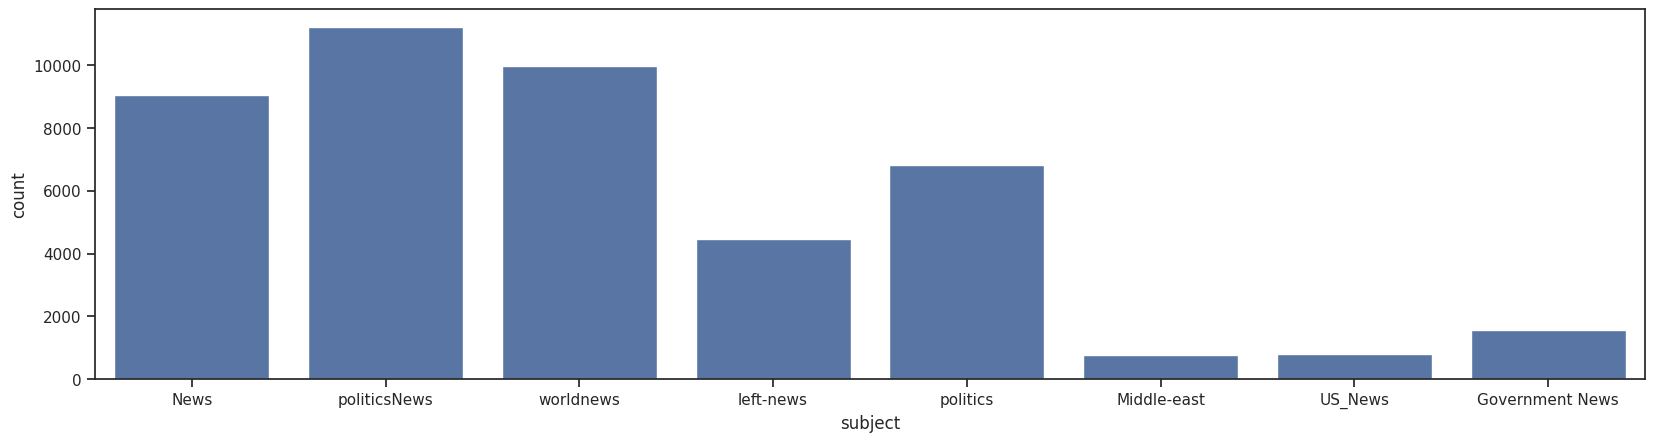

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

fig_dims = (20, 4.8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(x='subject', ax=ax, data=df_merged);

In [19]:
df_fake_news['label'] = 0
df_true_news['label'] = 1

In [20]:
df_train = pd.merge(df_fake_news, df_true_news, how='outer')

In [21]:
!pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [22]:
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer

Remove stopwords and punctuations

In [23]:
import string

In [24]:
from nltk.corpus import stopwords

In [25]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
def text_process(text):
  no_punctuation = [char for char in text if char not in string.punctuation]
  no_punctuation = ''.join(no_punctuation)
  return [word for word in no_punctuation.split() if word.lower() not in stopwords.words('english')]

**Model** **Creation** **and** **Training**

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df_train['title'] , df_train['label'], test_size=0.2, random_state=42)

In [29]:
# Deep learning Multi-perceptron neural network binary classifier

from sklearn.neural_network import MLPClassifier

In [30]:
from sklearn.pipeline import Pipeline

news_classifier = Pipeline([
('vectorizer',  CountVectorizer(analyzer=text_process)),
('tfidf', TfidfTransformer()),
('classifier', MLPClassifier(solver='adam', activation='tanh',
                                     random_state=1, max_iter=200,
                                     early_stopping=True))
])

In [31]:
news_classifier.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('vectorizer', ...), ('tfidf', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (strip_accents and lowercase) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


**Model Evaluation**

In [32]:
predicted = news_classifier.predict(X_test)

In [33]:
from sklearn.metrics import classification_report

In [34]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4786
           1       1.00      1.00      1.00      4152

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg       1.00      1.00      1.00      8938



**Saving model**

In [35]:
import joblib

In [36]:
joblib.dump(news_classifier, 'model.pkl')

['model.pkl']

**Model** **Deployment**

In [42]:

print("🔍 Fake News Detector - Enter titles to test:")
while True:
    user_title = input("\nEnter news title (or 'quit'): ")
    if user_title.lower() == 'quit':
        break

    pred = news_classifier.predict([user_title])[0]
    confidence = news_classifier.predict_proba([user_title]).max()
    status = " FAKE NEWS" if pred == 0 else " REAL NEWS"

    print(f"📝 '{user_title}'")
    print(f"🎯 Prediction: {status} (confidence: {confidence:.1%})")


🔍 Fake News Detector - Enter titles to test:

Enter news title (or 'quit'): Man has now landed on Mars successfully
📝 'Man has now landed on Mars successfully'
🎯 Prediction:  FAKE NEWS (confidence: 84.0%)

Enter news title (or 'quit'): quit


In [43]:
print(f"✅ Model Test Accuracy: {news_classifier.score(X_test, y_test):.1%}")
print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

✅ Model Test Accuracy: 99.8%
Train samples: 35751, Test samples: 8938
